# K-Means, Gaussian Mixtures, and the Expectation-Maximization Algorithm


## K-Means Algorithm

The k-Means algorithm is a specific example of the Expectation-Maximization (EM) algorithm
In k-Means, there are two main steps:
1. Expectation step - we freeze the current cluster centers or "prototypes" and assign each datapoint to a cluster that minimizes the sum of squared distances between the datapoint and the center of the assigner cluster
2. Maximization step - we freeze the cluster membership and update the location of each cluster center
We iterate between these two steps many times until the cluster memberships no longer change.

We can think of k-Means as a "hard clustering" algorithm where each datapoint belongs to exactly one cluster.

In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from PIL import Image
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

(960, 704, 3)
960 704


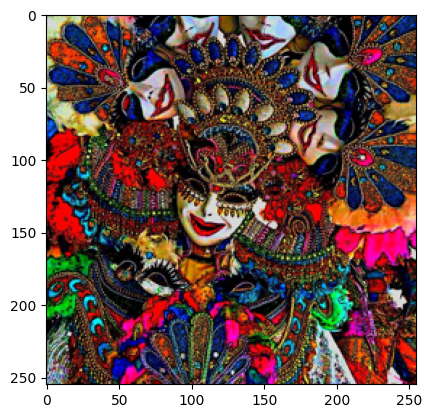

In [2]:
img = plt.imread("../data/mascara_bacolod.jpg")
# img = img/255
h, w, c = img.shape
print(img.shape)
print(h, w)
# crop
img = img[(h-w)//2:(h-w)//2 + w, :, :]
img = Image.fromarray(img).resize((255, 255))
img = np.array(img)/255
plt.imshow(img)

675840
(65025, 3)


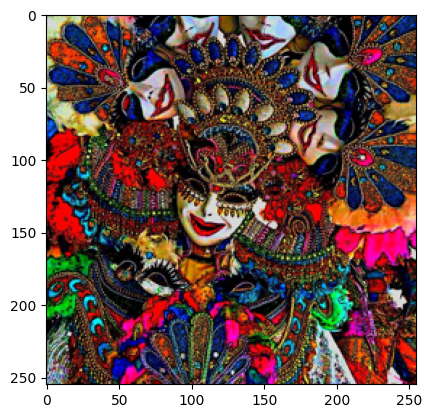

In [3]:
# count pixels
print(h * w)
# flatten so N rows (count pixels) and each row is flattened RGB vector
X = np.vstack(img)
print(X.shape)

# check reshape
img_reshape = np.reshape(X, img.shape)
plt.imshow(img_reshape)

In [4]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
# emb = TSNE(n_components=2, n_iter=250)
# emb = LocallyLinearEmbedding()
# emb = MDS(n_jobs=-1)
emb = Isomap(n_jobs=-1)

X_sample = X[np.random.choice(range(len(X)), size=3000, replace=False)]
emb.fit(X_sample)

Isomap(n_jobs=-1)

In [25]:
n_clusters = 30
cluster_centers_ = np.array([[0.5, 0.5, 0.5]]*n_clusters)

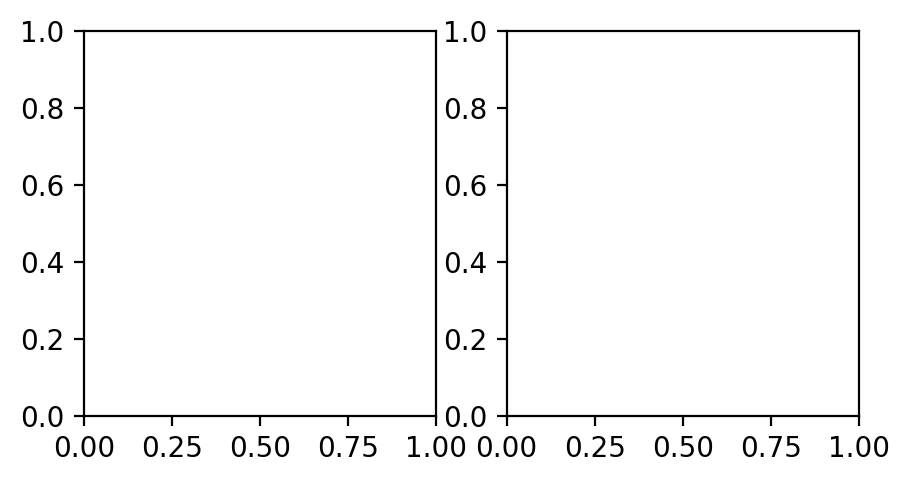

In [26]:
# animation
fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), dpi=200)
axs = axs.flatten()

def animate(iter):
    global cluster_centers_
    iter += 1
    [ax.clear() for ax in axs]

    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init=cluster_centers_, n_init=1, max_iter=1)    
    kmeans.fit(X)

    cluster_centers_ = kmeans.cluster_centers_
    
    # codebook
    cb = {i:k for i, k in enumerate(np.clip(kmeans.cluster_centers_, 0, 1))}    

    X_pred = np.array([cb[i] for i in kmeans.labels_])
    img_reshape = np.reshape(X_pred, img.shape)
    axs[0].imshow(img_reshape)

    X_2d = emb.transform(X)
    centers_2d = emb.transform(kmeans.cluster_centers_)

    axs[1].scatter(X_2d[:, 0], X_2d[:, 1], s=0.25, c=X_pred, alpha=1)
    axs[1].scatter(centers_2d[:, 0], centers_2d[:, 1], c='k', marker='*', s=50)
    axs[1].scatter(centers_2d[:, 0], centers_2d[:, 1], c='r', marker='*', s=10)

    axs[0].set_axis_off()
    axs[1].set_axis_off()

    axs[0].set_title(f"EM Iteration {str(iter).zfill(1)}")
    plt.tight_layout()    

    return None

We show an example of using K-Means algorithm for image compression, where we reduce the number of colors in an image. In this case, given a color image, our goal is to learn an encoding scheme such that we reduce the number of colors to only 30 colors. 

We show how initially, we start with all 30 colors to have the same `(0.5, 0.5, 0.5)` RGB values. But K-means is able to quickly figure out to adjust the clusters into distinct colors. Thus allowing us to have an image that is similar to our original image but with much fewer colors.

In the animation below, we see how this happens using the EM algorithm we discussed above. We show how the compressed image changes over time and how the different clusters and cluster centers (red star), move over time to optimize the colors.

In [27]:
anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=3, 
                               interval=1)
HTML(anim.to_jshtml(fps=5))

<Figure size 640x480 with 0 Axes>

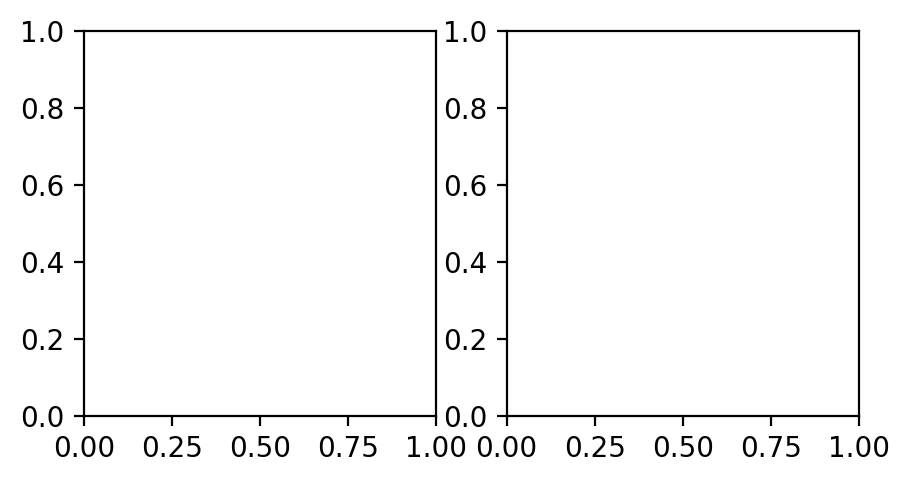

In [49]:
# animation
n_clusters = 30
cluster_centers_ = np.array([[0.5, 0.5, 0.5]]*n_clusters)

fig, axs = plt.subplots(1, 2, figsize=(5, 2.5), dpi=200)
axs = axs.flatten()
weights_init = None
def animate(iter):
    global cluster_centers_, weights_init
    
    iter += 1
    [ax.clear() for ax in axs]

    gm = GaussianMixture(n_components=n_clusters, n_init=1, init_params='random', 
                            means_init=cluster_centers_, weights_init=weights_init, 
                            random_state=0, max_iter=1, covariance_type='spherical')    

    gm.fit(X)

    cluster_centers_ = gm.means_
    weights_init = gm.weights_

    X_pred = (gm.predict_proba(X) @ gm.means_) # weighted average of colors
    img_reshape = np.reshape(X_pred, img.shape)
    axs[0].imshow(img_reshape)

    X_2d = emb.transform(X)
    centers_2d = emb.transform(gm.means_)

    axs[1].scatter(X_2d[:, 0], X_2d[:, 1], s=0.25, c=X_pred, alpha=1)
    axs[1].scatter(centers_2d[:, 0], centers_2d[:, 1], c='k', marker='*', s=50)
    axs[1].scatter(centers_2d[:, 0], centers_2d[:, 1], c='r', marker='*', s=10)

    axs[0].set_axis_off()
    axs[1].set_axis_off()

    axs[0].set_title(f"EM Iteration {str(iter).zfill(1)}")
    plt.tight_layout()    

    return None

## Gaussian Mixtures

There is a softer and more general counterpart to this algorithm which is the Gaussian Mixture model, which gives a "soft membership" such that each datapoint can be a member of more than one cluster with some probability. 

This too is learned via the EM algorithm above. In which case, the two steps are
1. Expectation step - Freeze the means, covariances of k Gaussians. Compute the degrees of membership of each datapoint to each cluster.
2. Maximization step - Freeze the degrees of membership. Compute the means, covariances, and mixture coefficients via maximum likelihood esimation of the Gaussian mixture model
Iterate between these two steps until convergence

We show an example of using Gaussian Mixtures algorithm for learning 30 Gaussian distributions that can plausibly give rise to our given image. In contrast to K-means compression, with Gaussian mixtures, we can come up with 30 colors as well as combinations of these 30 colors.

Like in our K-means example, we start with all 30 colors to have the same `(0.5, 0.5, 0.5)` RGB values. Gaussian mixture model is able to figure out to adjust the parameters (means, covariances, and mixture coeffficients) that are used to combine 30 colors into different combinations. 

In the animation below, we see how the  happens using the EM algorithm. We show how the predicted image color changes over time and how the different soft clusters and cluster centers (red star) move over time to optimize the colors.

In [50]:
anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=10, 
                               interval=1)
HTML(anim.to_jshtml(fps=5))

<Figure size 640x480 with 0 Axes>

In contrast to our K-means example, we cannot consider this as a compression algorithm because for each pixel, we store the unique probability values corresponding to each of the 30 Gaussian distribution components. And this actually increases the data size from storing 3-element RGB vectors per pixel to storing 30 values per pixel on top of the Gaussian means. 

Still, this is an illustration of the power of Gaussian mixture models to model the probability distribution of our data.

Clearly, given the complexity of applying EM on Gaussian mixtures, it is much more computionally intensive than k-Means.
In order to improve efficiency, it will make sense to first apply k-Means, then use the resulting centers, cluster covariances, and cluster proportions as the initial means, covariances, and mixture coefficients of the Gaussian mixture. The we can use EM as is.

Note that there is one big problem with Gaussian Mixture optimization via EM or maximum likelihood in general. And that is that it is susceptible to fitting a Gaussian component to a single datapoint where the variance goes to 0. In which case, because of the math, this leads to the likelihood value to go to infinity. This can be addresser by adding a regularization on the parameters of each component to prevent it from going to 0 or overfitting on a single datapoint.